# Toy notebook to make optimization fxns

In [1]:
import sys
import os
sys.path.append("src/")
from src import *
sys.path.append("scripts/")
from ixnos_retrain import *
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from Bio import SeqIO
import seaborn as sns
import random

ALPHA = "ACGT"  # Defines the possible nucleotides
NTS = ["A", "C", "G", "T"]  # Nucleotide list
CODONS = [x + y + z for x in ALPHA for y in ALPHA for z in ALPHA]
COD2ID = {codon: idx for idx, codon in enumerate(CODONS)}  # Codon to ID mapping
ID2COD = {idx: codon for codon, idx in COD2ID.items()}  # ID to Codon mapping
NT2ID = {nt: idx for idx, nt in enumerate(NTS)}  # Nucleotide to ID mapping
ID2NT = {idx: nt for nt, idx in NT2ID.items()}  # ID to Nucleotide mapping
NT_INDICES = np.arange(-15, 15)  # Nucleotide indices window
CODON_INDICES = np.arange(-5, 5)  # Codon indices window


In [2]:
model_path = "models/ixnos_retrained.pth"
model = iXnos(min_codon=-5, max_codon=4)
model.load_state_dict(torch.load(model_path, weights_only=True))
# model = torch.load(model_path, weights_only=False)
model.eval()

TypeError: iXnos.__init__() got an unexpected keyword argument 'min_codon'

## 1. Given nt seq, run iXnos model on all codons
(Except first/last 20)

In [ ]:
iwasaki_dir = "iXnos/expts/iwasaki"
ydf_te = pd.read_csv(
    f"{iwasaki_dir}/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')
ydf_tr = pd.read_csv(
    f"{iwasaki_dir}/process/tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')
# Get the train and test genes
genes_te = ydf_te["gene"].unique()
genes_tr = ydf_tr["gene"].unique()
# Combine these dataframes and encode each codon
ydf = pd.concat([ydf_te, ydf_tr]).sort_values(by=["gene", "cod_idx"])
gdf_path = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"
gdf = load_gdf(ydf, gdf_path)

In [ ]:
# Just gonna grab a complete CDS for one gene
start_codon = "ATG"
stop_codons = ['TAA', 'TAG', 'TGA']

complete_seq = gdf.iloc[0]["seq"]
start_codon_idx = complete_seq.find(start_codon)
coding_seq = complete_seq[start_codon_idx:]
codons = [coding_seq[i:i+3] for i in range(0, len(coding_seq), 3)]

stop_indices = []
for stop_codon in stop_codons:
    if stop_codon in codons:
        stop_codon_i_idx = codons.index(stop_codon)
        print(stop_codon, stop_codon_i_idx)
        stop_indices.append(stop_codon_i_idx)
stop_index = min(stop_indices)
# Final results:
codons = codons[:stop_index + 1]
coding_seq = "".join(codons)


TAG 459


In [ ]:
# i = 20
# print(codons[i])
def predict_elongation(seq, model, min_cod=-5, max_cod=4):
    """Given a sequence and an iXnos model, predict the sum of
    scaled counts at each codon index.

    Args:
        seq (str): Amino acid sequence of transcript of interest.
        model (iXnos model): iXnos model to use
        min_cod (int, optional): Minimum index of codons used in iXnos model. Defaults to -5.
        max_cod (int, optional): Maximum index of codons used in iXnos model. Defaults to 4.

    Returns:
        int: Sum of scaled counts; proxy for predicted elongation time
    """    
    seq = seq.upper()
    # I train iXnos on DNA sequences, so need to convert U to T
    if "U" in seq:
        seq = seq.replace("U", "T")
    # Add "NNN" codons to beginning and end of sequence in order to pass 
    # first and last few codons through iXnos
    seq = "".join(["NNN" for i in range(0 - min_cod)]) \
        + seq + "".join(["NNN" for i in range(max_cod)])
    # Predict scaled counts across all codons
    codons = [seq[i:i+3] for i in range(0, len(seq), 3)]
    overall_count = 0
    for i in range(0 - min_cod, len(codons) - max_cod):
        input_vector = get_inputs(codons[i + min_cod:i + max_cod + 1])
        overall_count += model(input_vector).item()
    return overall_count
# def predict_total_speed(codons, model):
#     predictions = []
#     for i in range(20, len(codons) - 20): # FOR LOOP INDEXING!!!
#         footprint_codons = codons[i+min(CODON_INDICES):i+max(CODON_INDICES) + 1]
#         footprint_nt = "".join(footprint_codons)

#         codon_vector = np.concatenate([encode(i, COD2ID) for i in footprint_codons])
#         nt_vector = np.concatenate([encode(i, NT2ID) for i in footprint_nt])
#         input_vector = np.concatenate([codon_vector, nt_vector])
#         input_vector = torch.from_numpy(input_vector).to(torch.float32)
#         prediction = model(input_vector).item()
#         predictions.append(prediction)
#     return sum(predictions)

predict_total_speed(codons, model)

429.59519469738007

In [ ]:
len(codons[20:-20]) - len(codons)

-40

In [ ]:
# def get_inputs(row):
#     # Get input vectors for a given row of the y dataframe.
#     gdf_gene = gdf.loc[row["gene"]]
#     gdf_seq = gdf_gene["seq"]
#     # Get index of E site in fasta sequence
#     esite_index = (row["cod_idx"] - 20) * 3 + gdf_gene["start"] 
#     # Find the nucleotides in the window
#     footprint_nt = gdf_seq[
#         esite_index + NT_INDICES[0]:
#         esite_index + NT_INDICES[-1] + 1]
#     # Convert nt string into codons 
#         # NOTE: assumes your nt footprint is an in frame CDS containing just the codons we wanna look at
#     footprint_codons = [footprint_nt[i:i+3] for i in range(0, len(footprint_nt), 3)]
#     print(footprint_codons)
#     # Assemble input tensor
#     codon_vector = np.concatenate([encode(i, COD2ID) for i in footprint_codons])
#     nt_vector = np.concatenate([encode(i, NT2ID) for i in footprint_nt])
#     input_vector = np.concatenate([codon_vector, nt_vector])
#     input_vector = torch.from_numpy(input_vector).to(torch.float32)
#     return input_vector
# print(ydf.iloc[0])
# # get_inputs(ydf.iloc[0])

## 2. Given an AA sequence, generate random nt seqs and pass to model

In [ ]:
cit_seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLGYGLMCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

let2cod = {
    'F': ['TTT', 'TTC'],
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
    'I': ['ATT', 'ATC', 'ATA'],
    'M': ['ATG'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'Y': ['TAT', 'TAC'],
    'H': ['CAT', 'CAC'],
    'Q': ['CAA', 'CAG'],
    'N': ['AAT', 'AAC'],
    'K': ['AAA', 'AAG'],
    'D': ['GAT', 'GAC'],
    'E': ['GAA', 'GAG'],
    'C': ['TGT', 'TGC'],
    'W': ['TGG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
}

In [ ]:
def predict_random_speeds(cds, n_samples, model, **kwargs):
    seqs, speeds = [], []
    for i in range(n_samples):
        codons = [random.choice(let2cod[i]) for i in cds]
        nt_seq = "".join(codons)
        pred_speed = predict_elongation(nt_seq, model, **kwargs)
        seqs.append(nt_seq)
        speeds.append(pred_speed)
    return seqs, speeds

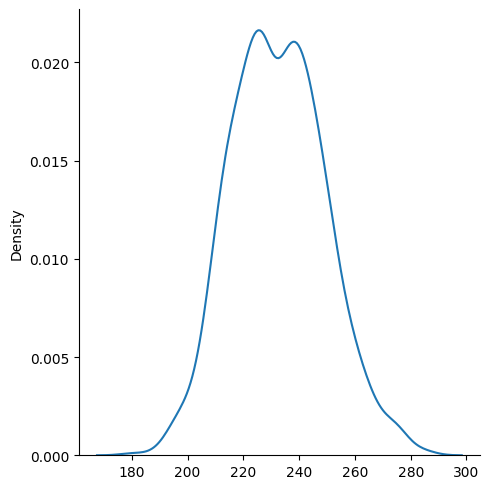

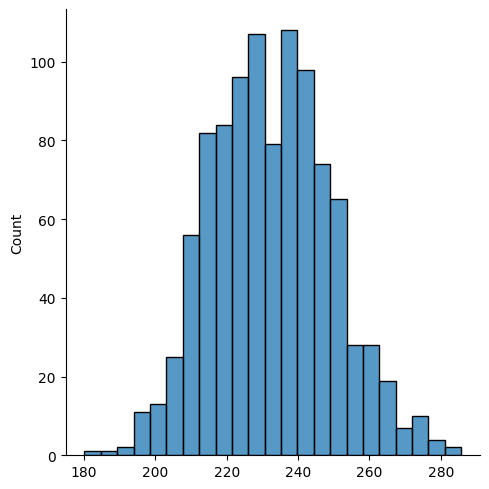

In [ ]:
seqs, speeds = predict_random_speeds(cit_seq, 1000, model=model)
sns.displot(speeds, kind="kde")
sns.displot(speeds,)
plt.show()

## 3. Overall optimize

In [ ]:
import itertools
import torch
from ixnos import iXnos, encode


def get_inputs(codons : list):
    nts = "".join(codons)
    codon_vector = np.concatenate([encode(i, COD2ID) for i in codons])
    nt_vector = np.concatenate([encode(i, NT2ID) for i in nts])
    input_vector = np.concatenate([codon_vector, nt_vector])
    input_vector = torch.from_numpy(input_vector).to(torch.float32)
    return input_vector

# PARAMETERS!!!
seq = cit_seq[:8]
# seq = "MWMW" + "".join(["F" for _ in range(20)])
c_rel_min, c_rel_max = -3, 2
L = len(seq)
Q = [[] for _ in range(L - c_rel_max)]
T = [[] for _ in range(L - c_rel_max)]
c_min = np.zeros(L, dtype=int)
c_max = np.zeros(L, dtype=int)
# Load in model
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = iXnos(n_codons=6).to(device)
model_path = "processed-data/iwasaki/models/ixnos_n3p2_full.pth"
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

# TODO: should change this to look at the rightmost codon instead of the A site one, right?
for i in range(L - c_rel_max):
    c_min[i] = max(0, i + c_rel_min) # Originally this is 1 but I think it needs to be 0-based
    c_max[i] = min(L, i + 1 + c_rel_max)
    # print(i, ": ", c_min[i], c_max[i], len(range(c_min[i], c_max[i])), "\n\t L = ", L)
    possible_codons = [let2cod[k] for k in [seq[j] for j in range(c_min[i], c_max[i])]]
    Q[i] = list(itertools.product(*possible_codons))
    if i + c_rel_min < 0:
        prefix_list = ["NNN" for _ in range(c_min[i]  - (i + c_rel_min))]
        Q[i] = [prefix_list + list(i) for i in Q[i]]
    for q in Q[i]:
        input_vector = get_inputs(q).to(device)
        T[i].append(model(input_vector).item())

In [ ]:
P = [[] for _ in range(L - c_rel_max)]
V = [[] for _ in range(L - c_rel_max)]

# TODO: breakpoints should be 0 indices right
for i in range(L):
    if c_min[i] == 1:
        for q_i, q in enumerate(Q[i]):
            P[i].append(np.nan)
            V[i].append(T[i][q_i])
    elif c_min[i] > 1:
        for q_i, q in enumerate(Q[i]):
            # First finds Q[i-1] sequences that match all but the last codon for a given q, 
            # then finds the argmin of V[i-1] subsetted to those sequences
            P_i_q = np.argmin(
                [V[i - 1][k] for k in [
                    all(a == b for a, b in zip(q[:-1], q_i[1:])) for q_i in Q[i-1]
                    ] if k])
            P[i].append(P_i_q)
            V[i].append(V[i-1][P_i_q] + T[i][q_i])

NameError: name 'L' is not defined

In [ ]:
q_L = np.argmin(V[L - c_rel_max - 1])
i = L - c_rel_max - 1
q_i = q_L
cds = "".join(Q[L - c_rel_max - 1][q_L])
while c_min[i] > 1:
    i -= 1
    q_i = Q[i][np.argmin(V[i])]
    cds = q_i[0] + cds
cds = "ATG" + cds
cds

'ATGTCCAAGGGGGAGGAATTGTTT'

In [ ]:
predict_elongation(cds, model, -3, 2)

0.3385429382324219

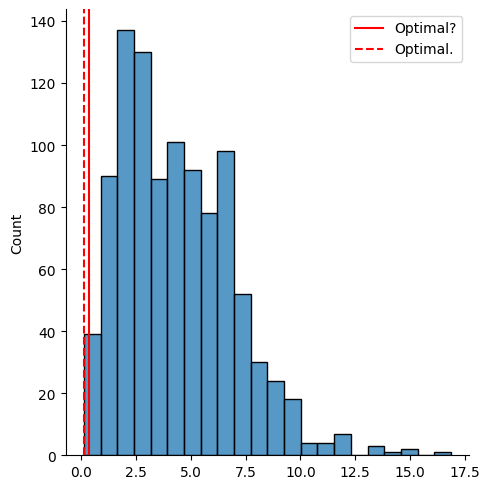

In [ ]:
sns.displot(predict_random_speeds(seq, 1000, model, min_cod=-3, max_cod=2)[1])
plt.axvline(predict_elongation(cds, model, -3, 2), c='r', label="Optimal?")
plt.axvline(min(all_speeds), c='r', linestyle="--", label="Optimal.")
plt.legend()
plt.show()


In [ ]:
assert(len(seq) < 10)
all_seqs = ["".join(i) for i in list(itertools.product(*[let2cod[i] for i in seq]))]
all_speeds = [predict_elongation(i, model, min_cod=-3, max_cod=2) for i in all_seqs]

In [ ]:
optimal = all_seqs[np.argmin(all_speeds)]
print(optimal)
print(cds)

ATGTCCAAGGGTGAGGAATTGTTT
ATGTCCAAGGGGGAGGAATTGTTT


In [ ]:
# CHATGPT VERSION
def translation_rate_optimization(codons, model, c_min_rel=-7, c_max_rel=5):
    """
    Performs translation rate optimization using a predictive neural network model.
    
    Parameters:
    - codons: A list or array of amino acid sequence (represented as codons).
    - model: A pre-trained PyTorch model to predict the translation rate.
    - c_min_rel: The minimum relative index for the codon neighborhood (default is -7).
    - c_max_rel: The maximum relative index for the codon neighborhood (default is 5).
    
    Returns:
    - optimized_cds: The optimized codon sequence based on the model prediction.
    """
    
    # # Define the set of synonymous codons for each amino acid (ϕ(a)).
    # def get_synonymous_codons(a):
    #     # This function should return the set of synonymous codons for a given amino acid.
    #     # For simplicity, here we're using a dummy map of amino acids to codons.
    #     codon_dict = {
    #         'A': ['GCT', 'GCC', 'GCA', 'GCG'],  # Example codons for Alanine
    #         'C': ['TGT', 'TGC'],  # Example codons for Cysteine
    #         'D': ['GAT', 'GAC'],  # Example codons for Aspartic Acid
    #         # Add mappings for all amino acids...
    #     }
    #     return codon_dict.get(a, [])

    # Function to calculate the set of all neighborhoods for a given sequence
    def calculate_neighborhoods(seq, c_min_rel, c_max_rel):
        neighborhoods = []
        for i in range(len(seq)):
            c_min_i = max(1, i + c_min_rel)
            c_max_i = min(i + c_max_rel, len(seq))
            neighborhood = seq[c_min_i:c_max_i]
            neighborhoods.append(neighborhood)
        return neighborhoods
    
    # Step 1: Calculate Qi for each codon position
    neighborhoods = calculate_neighborhoods(codons, c_min_rel, c_max_rel)
    
    # Step 2: Predict translation rates for each neighborhood
    Ti_q = {}
    for i, neighborhood in enumerate(neighborhoods):
        for q in neighborhood:
            # Convert the sequence to a tensor for model input
            input_tensor = torch.tensor([q], dtype=torch.float32)  # Adjust this based on model input requirements
            Ti_q[(i, tuple(q))] = model(input_tensor).item()  # Assuming model output is a scalar value
    
    # Step 3: Initialize Pi,q and Vi,q
    Pi_q = {}
    Vi_q = {}
    for i, neighborhood in enumerate(neighborhoods):
        for q in neighborhood:
            Pi_q[(i, tuple(q))] = None
            Vi_q[(i, tuple(q))] = Ti_q[(i, tuple(q))]
    
    # Step 4: Perform the iterative optimization
    for i in range(len(codons)):
        c_min_i = max(1, i + c_min_rel)
        for q in neighborhoods[i]:
            if c_min_i > 1:
                prev_q = neighborhoods[i-1]
                prev_P = Pi_q.get((i-1, tuple(prev_q)))
                Vi_q[(i, tuple(q))] = min(Ti_q[(i, tuple(q))], Vi_q[(i-1, tuple(prev_q))] + Ti_q[(i, tuple(q))])
            else:
                Vi_q[(i, tuple(q))] = Ti_q[(i, tuple(q))]
    
    # Step 5: Backtrack to reconstruct the optimized codon sequence
    optimized_sequence = []
    i = len(codons) - 1
    qL = min(Vi_q[(i, tuple(q))] for q in neighborhoods[i])
    cds = qL
    while i >= 0:
        q = Pi_q.get((i, tuple(qL)))
        cds = qL[:3] + cds
        i -= 1
    
    # Step 6: Return the optimized codon sequence
    return cds

translation_rate_optimization(list(seq), model, -3, 2)

ValueError: too many dimensions 'str'

In [ ]:
import pandas as pd
df = pd.read_csv("processed-data/citrine_fluorescence_expanded.csv")
cds_orig = df.loc[df["cit"] == "citmin", "seq"].unique().item()

In [ ]:


print(predict_elongation(cds, model, min_cod=-3, max_cod=2))
print(predict_elongation(cds_orig, model, min_cod=-3, max_cod=2))

189.96628922224045
138.70385026931763


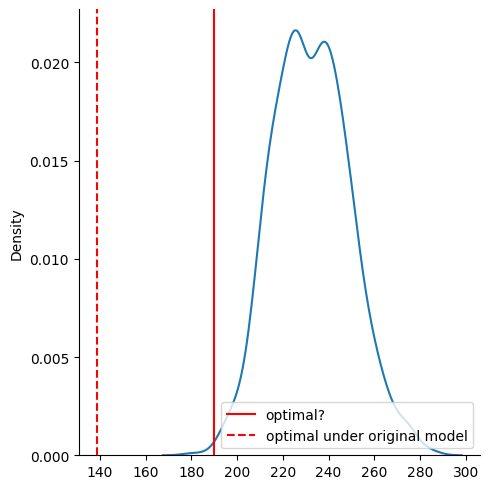

In [ ]:
sns.displot(speeds, kind="kde")
plt.axvline(predict_elongation(cds, model, min_cod=-3, max_cod=2), c='r', label="optimal?")
plt.axvline(predict_elongation(cds_orig, model, min_cod=-3, max_cod=2), c='r', linestyle="--", label="optimal under original model")
plt.legend(loc="lower right")

plt.show()